In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

%matplotlib inline

import warnings 
warnings.filterwarnings('ignore')

In [2]:
import datetime

In [3]:
data = pd.read_csv('/Users/chaule/Downloads/ds/EDAs/walmart/Walmart.csv')

In [4]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [5]:
df = data.copy()

**Quick look at data**

In [6]:
df.shape

(6435, 8)

In [7]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [8]:
df.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

=> No missing values

In [9]:
#convert the date format to datetime
df['Date'] = pd.to_datetime(df['Date'], format ='%d-%m-%Y')

In [10]:
#how many Walmart stores in this dataset?
df['Store'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

In [11]:
#Add day, month and year columns from Date series
df['Day'] = df['Date'].dt.day_name()
df['Month'] = df['Date'].dt.month_name().str[:3]
df['Year'] = df['Date'].dt.year

## Outliers


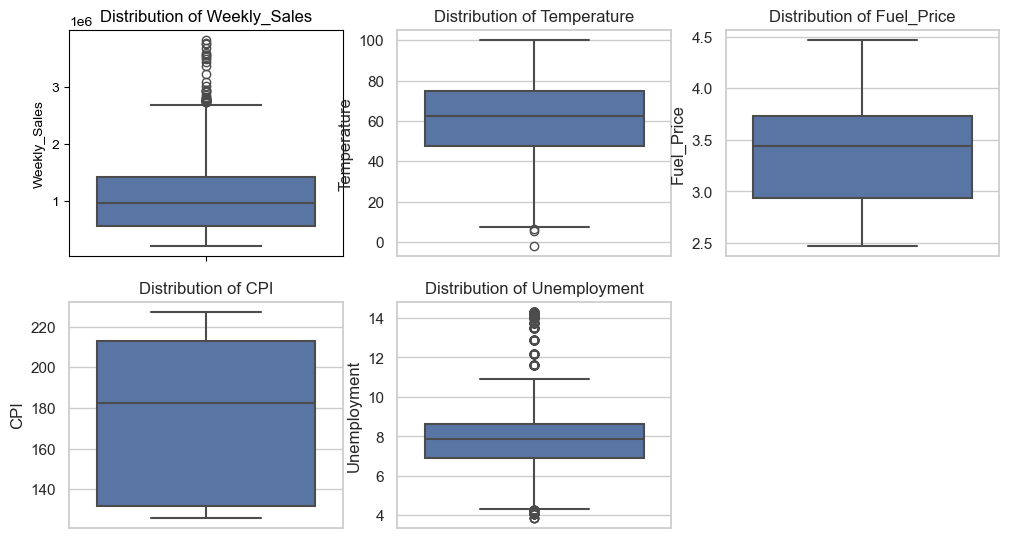

In [12]:
cols = ['Weekly_Sales','Temperature','Fuel_Price','CPI','Unemployment']
plt.figure(figsize=(12,10))

for i in range(0,len(cols)):
    plt.subplot(3,3,i+1)
    sns.boxplot(y=cols[i], data= df,palette = sns.color_palette('deep', n_colors=5), linewidth=1.5)
    sns.set(style='whitegrid')
    plt.title(f'Distribution of {cols[i]}')


=> Weekly_Sales, Temperature and Unemployment are the series which contain outliers

In [13]:
def remove_outlier(df, cols):
    for col in cols:
        Q1=df[col].quantile(0.25)
        Q3=df[col].quantile(0.75)
        IQR=Q3-Q1
        upper_limit= Q3+1.5*IQR
        lower_limit= Q1-1.5*IQR
        df = df[df[col] < upper_limit]
        df = df[df[col] > lower_limit]
    return df
df=remove_outlier(df, cols)

In [14]:
df.shape

(5917, 11)

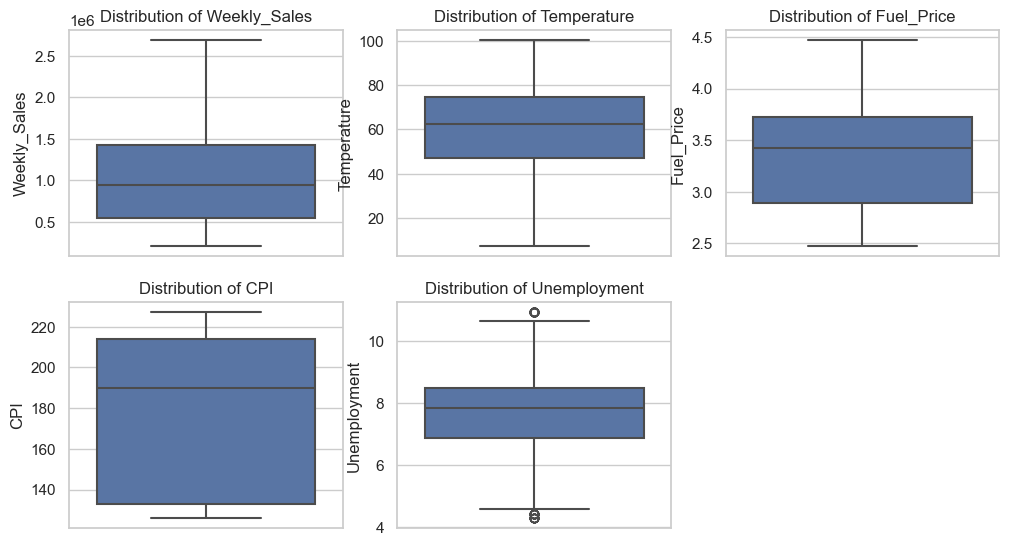

In [15]:
#Check if any outliers left in the data
cols = ['Weekly_Sales','Temperature','Fuel_Price','CPI','Unemployment']

plt.figure(figsize=(12,10))

for i in range(0,len(cols)):
    plt.subplot(3,3,i+1)
    sns.boxplot(y=cols[i], data= df,palette =sns.color_palette('deep', n_colors=5), linewidth=1.5)
    sns.set(style='whitegrid')
    plt.title(f'Distribution of {cols[i]}')

In [16]:
#For each store, what week(s) has the highest fuel price?
df.groupby(['Store','Date']).agg({'Fuel_Price': 'max'})['Fuel_Price'].nlargest()

Store  Date      
10     2012-10-12    4.468
12     2012-10-12    4.468
28     2012-10-12    4.468
33     2012-10-12    4.468
38     2012-10-12    4.468
Name: Fuel_Price, dtype: float64

In [17]:
# Find the week that has the lowest sales in each store, then group it with the temperature
df.groupby(['Store','Temperature']).agg({'Weekly_Sales': 'min'})['Weekly_Sales'].nsmallest(10)

Store  Temperature
33     52.82          209986.25
       71.34          213538.32
       51.60          215359.21
       52.91          219804.85
       59.12          220060.35
       94.00          224031.19
       91.45          224294.39
       61.95          224639.76
       95.28          224806.96
       98.43          226702.36
Name: Weekly_Sales, dtype: float64

=> we anticipate that store 33 generates the lowest weekly sales among other stores

<h1> EDA </h1>

Numerical values:
- CPI
- Temperature
- Fuel_Price
- Unemployment

<h3> Distribution </h3>

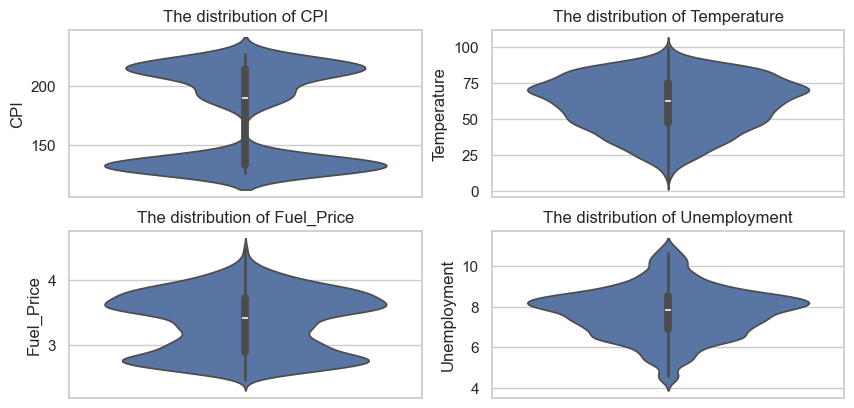

In [18]:
plt.figure(figsize=(10,10))
cols = ['CPI', 'Temperature','Fuel_Price','Unemployment']
for i in range(0, len(cols)):
    plt.subplot(4,2,i+1)
    sns.violinplot(y=cols[i], data=df).set_title(f'The distribution of {cols[i]}')

plt.show()

<h3> Holiday and Weekly Sales </h3>

what week has the holiday_flag, the relation between the sales and holiday week, and sales with no holiday week?


In [19]:
holiday = df['Holiday_Flag'] == 1

mean_holiday = df[(holiday)]['Weekly_Sales'].mean()
mean_holiday

1088710.2884841077

In [20]:
non_holiday = df['Holiday_Flag'] == 0

mean_non_holiday = df[(non_holiday)]['Weekly_Sales'].mean()
mean_non_holiday

1035645.0108787218

<Figure size 1000x800 with 0 Axes>

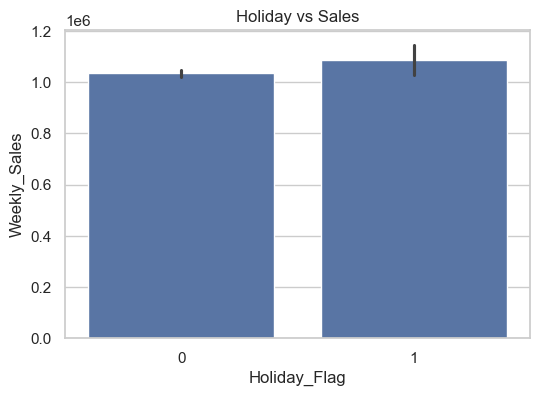

In [21]:
plt.figure(figsize =(10,8))
fig, ax = plt.subplots(figsize=[6,4])

sns.barplot(x = df['Holiday_Flag'], y= df['Weekly_Sales'], data = df)
ax.set_title('Holiday vs Sales')
plt.show()


=> The sales increase when there are holidays

<h3> Relations between Weekly Sales and other features </h3>

In [22]:
# When temp is cold/hot, how does it affect the sales?
bins = [7.46, 20,40,60,80,100.14]
labels =['< 20','From 20 to 40','From 40 to 60','From 60 to 80','> 80']
df['Temperature Category'] = pd.cut(x=df['Temperature'], bins=bins,
                    labels=labels)
df.head()


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Day,Month,Year,Temperature Category
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,Friday,Feb,2010,From 40 to 60
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,Friday,Feb,2010,From 20 to 40
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,Friday,Feb,2010,From 20 to 40
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,Friday,Feb,2010,From 40 to 60
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,Friday,Mar,2010,From 40 to 60


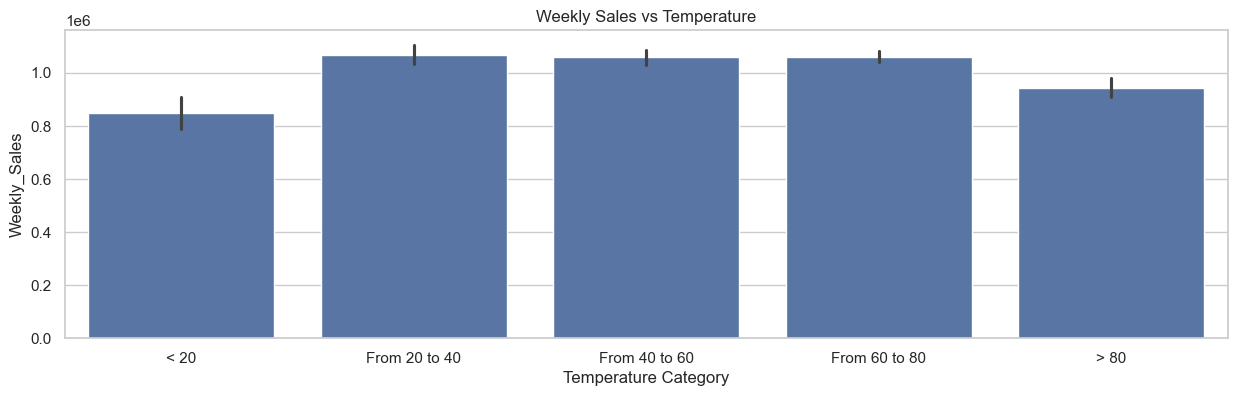

In [23]:
plt.figure(figsize=(15,4))
sns.barplot(x=df['Temperature Category'], y=df['Weekly_Sales'], data=df).set(title='Weekly Sales vs Temperature')
plt.show()

=> When the weather is colder, the sales go down accordingly

<h3> CPI (Consumer Price Index) vs Weekly Sales </h3>

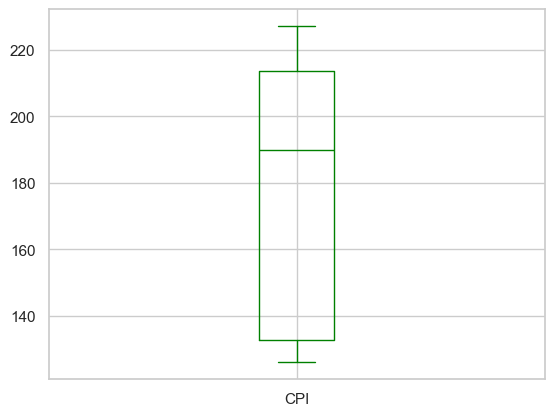

In [24]:
df[['CPI']].boxplot(color='green')
plt.show()

- The maximum value is approximately 224
- The minimum value is approximately 130
- The median value is approximately 189
- This box plot is skewed to the right

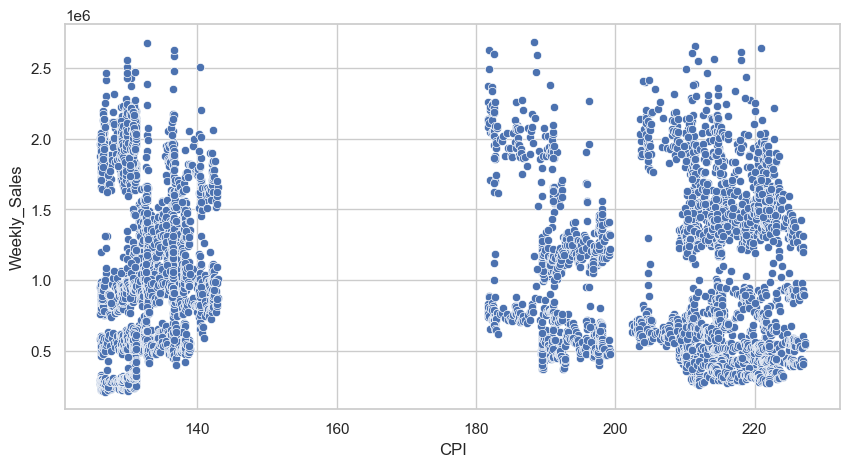

In [25]:
#the relation between CPI Vs. Weekly_Sales
plt.figure(figsize=(10,5))

sns.scatterplot(x = df["CPI"], y = df["Weekly_Sales"])
plt.show()

<h3> Fuel Price Vs Weekly Sales </h3>

In [26]:
bins = [2.472, 3.4, 4.5 ]
labels =['2.4 to 3.4', '3.4 to 4.5']
df['Fuel Category'] = pd.cut(x=df['Fuel_Price'], bins=bins, labels=labels)
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Day,Month,Year,Temperature Category,Fuel Category
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,Friday,Feb,2010,From 40 to 60,2.4 to 3.4
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,Friday,Feb,2010,From 20 to 40,2.4 to 3.4
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,Friday,Feb,2010,From 20 to 40,2.4 to 3.4
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,Friday,Feb,2010,From 40 to 60,2.4 to 3.4
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,Friday,Mar,2010,From 40 to 60,2.4 to 3.4


In [27]:
df['Fuel_Price'] = df['Fuel_Price'].drop_duplicates()

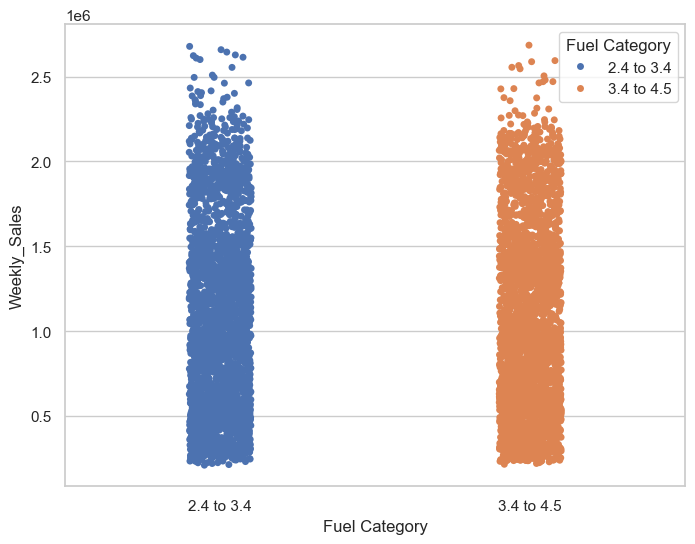

In [28]:
plt.figure(figsize=(8,6))

sns.stripplot(x=df['Fuel Category'], y=df['Weekly_Sales'], data=df, hue='Fuel Category')
plt.show()

<h3>Unemployment Vs Weekly Sales </h3>

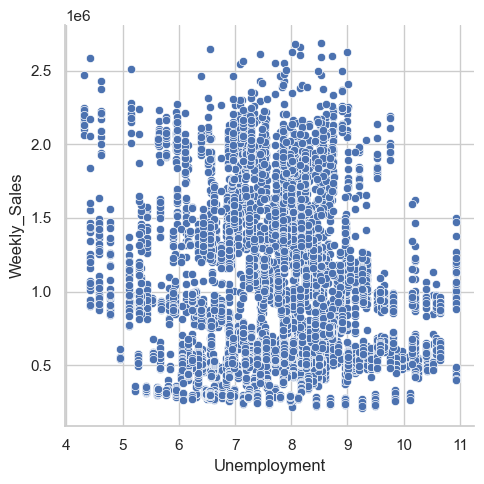

In [29]:
sns.relplot(x="Unemployment", y="Weekly_Sales", data=df);

=> When the rate of unemployment at peak, the sales is at the lowest.


The common unemployment rate is between 6 and 9 

In [30]:
une = df['Unemployment'].drop_duplicates().T

<h3> Top 5 Stores Each Year </h3>

In [31]:
# Top 5 store in 2010
year_list = [2010,2011,2012]
for i in range(0,len(year_list)):
    df[df['Year']== year_list[i]].groupby('Store')['Weekly_Sales'].sum().sort_values(ascending=False).head(5)


In [32]:
top5_2010 = df[df['Year']== 2010].groupby('Store')['Weekly_Sales'].sum().sort_values(ascending=False).head(5)
print(f'Top 5 store scored the most sales in 2010:')
top5_2010.to_frame()


Top 5 store scored the most sales in 2010:


,Weekly_Sales
Store,
14,95958984.81
2,91841856.51
20,89583444.00
27,86935014.49
4,86624230.83


In [33]:
top5_2011 = df[df['Year']== 2011].groupby('Store')['Weekly_Sales'].sum().sort_values(ascending=False).head(5)
print(f'Top 5 store scored the most sales in 2011:')
top5_2011.to_frame()


Top 5 store scored the most sales in 2011:


,Weekly_Sales
Store,
14,1.027272e+08
4,1.016398e+08
20,1.006126e+08
2,9.538351e+07
13,9.535623e+07


In [34]:
top5_2012 = df[df['Year']== 2012].groupby('Store')['Weekly_Sales'].sum().sort_values(ascending=False).head(5)
print(f'Top 5 store scored the most sales in 2012:')
top5_2012.to_frame()

Top 5 store scored the most sales in 2012:


,Weekly_Sales
Store,
20,89827709.38
13,86707455.02
2,81496695.37
10,78228616.94
14,77441398.26


## How to plot a pie chart of top 5 stores per year ????!!!!!!

<h3> Highest Monthly Sales Per Year </h3>

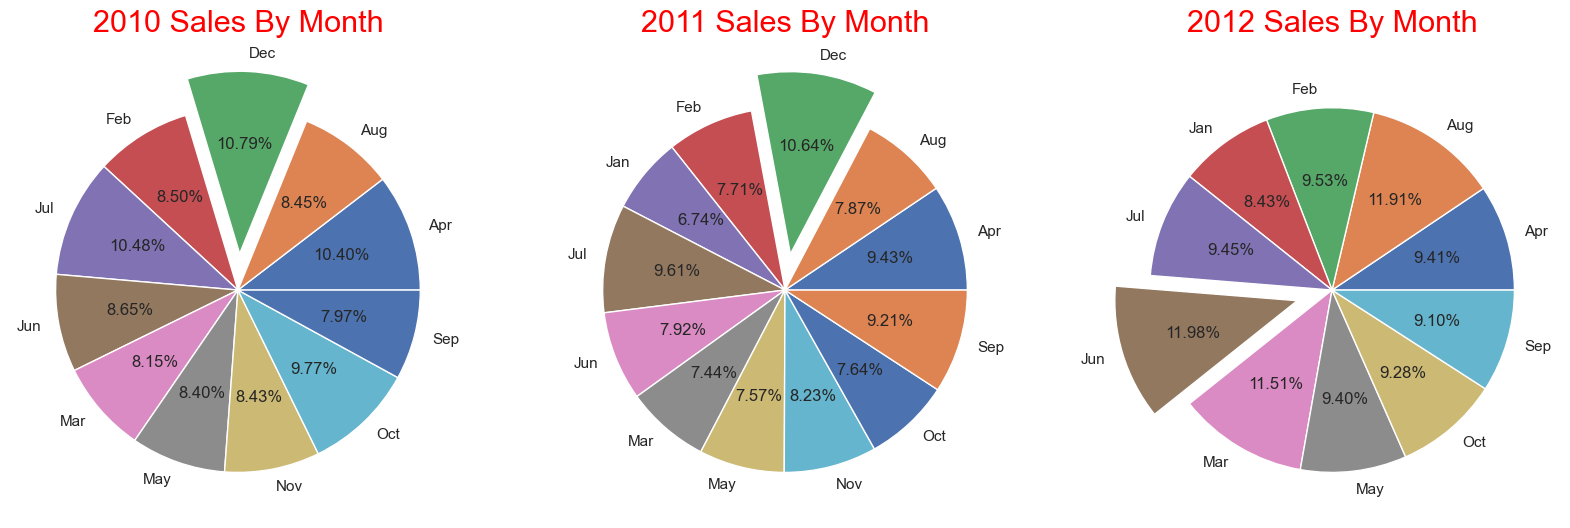

In [35]:
plt.figure(figsize = (20,15))
year_2010 = df[df['Year'] == 2010]
year_2011 = df[df['Year'] == 2011]
year_2012 = df[df['Year'] == 2012]
df_years = [year_2010, year_2011, year_2012]
years=['2010', '2011', '2012']

for i in range(0,len(df_years)):
    plt.subplot(1,3,i+1)
    val = df_years[i].groupby('Month')['Weekly_Sales'].sum().values
    max_val = max(val)
    exp_val = tuple([0 if val[j] != max_val else 0.2 for j in range(0, len(val))])
    plt.pie(val, labels = df_years[i].groupby('Month')['Weekly_Sales'].sum().index , autopct ='%.2f%%', explode=exp_val)
    plt.title(f'{years[i]} Sales By Month', color='red', fontsize= 22, pad=22)
    

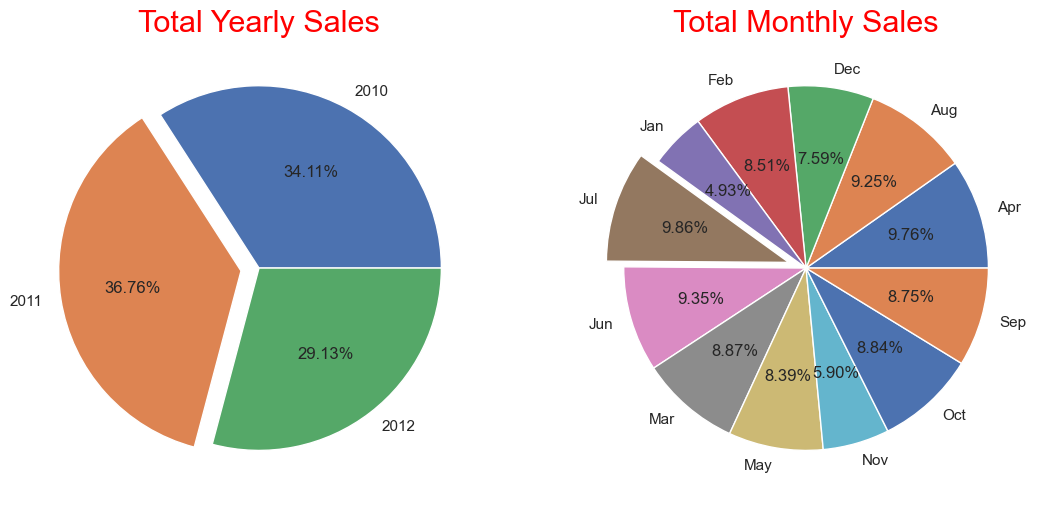

In [36]:
plt.figure(figsize=(20,15))
label_col = ['Year','Month']
titles = ['Yearly','Monthly']

for i in range(0,len(label_col)):
    plt.subplot(1,3,i+1)
    val2 = df.groupby(label_col[i])['Weekly_Sales'].sum().values
    max_val2 = max(val2)
    explode_val= tuple([0 if val2[j] != max_val2 else 0.1 for j in range(len(val2))])
    plt.pie(df.groupby(label_col[i])['Weekly_Sales'].sum().values, labels=df.groupby(label_col[i])['Weekly_Sales'].sum().index, autopct='%.2f%%', explode=explode_val)
    plt.title(f'Total {titles[i]} Sales', color='red', fontsize=22)
    
    

<h3> Total Sales Over The Three Years </h3>

In [37]:
sales = df.groupby(['Year','Month'])['Weekly_Sales'].sum()
df_sales = pd.DataFrame(sales)
df_sales = df_sales.reset_index()
df_sales

,Year,Month,Weekly_Sales
0,2010,Apr,2.182086e+08
1,2010,Aug,1.772900e+08
2,2010,Dec,2.262664e+08
3,2010,Feb,1.783441e+08
4,2010,Jul,2.199126e+08
5,2010,Jun,1.814865e+08
6,2010,Mar,1.710599e+08
7,2010,May,1.762177e+08
8,2010,Nov,1.769412e+08
9,2010,Oct,2.049394e+08


Text(0.5, 1.0, 'Total Sales Over Three Years')

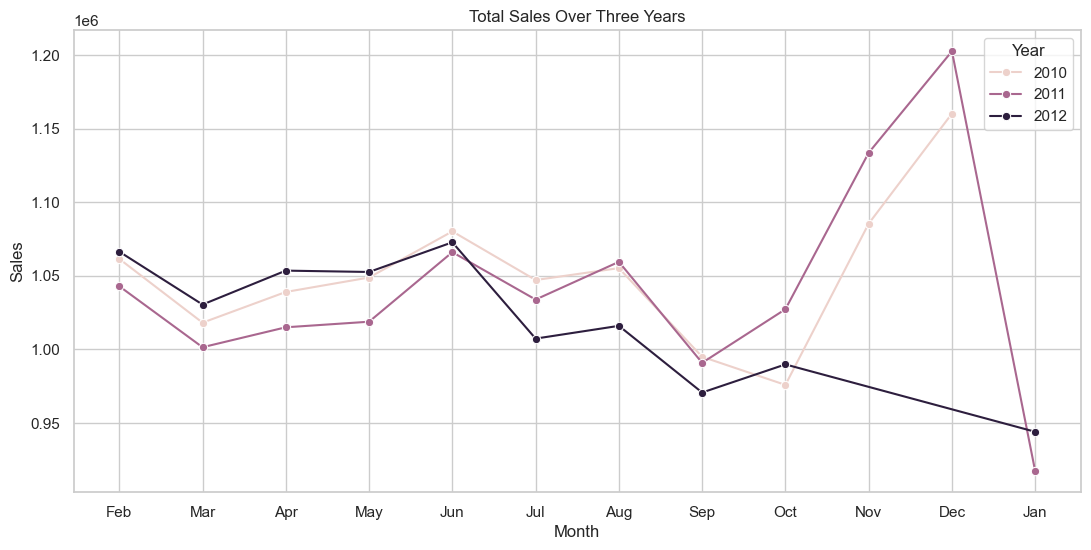

In [38]:
from calendar import month_name as mn
months = mn[1:]

df_sales['Month'] = pd.Categorical(df_sales['Month'], categories=months, ordered=True)

plt.figure(figsize=(13,6))
sns.lineplot(data=df, x='Month',y='Weekly_Sales', hue='Year', marker='o', ci=None)
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Total Sales Over Three Years')

=> The sales skyrocketed during the holidays in 2010 and 2011

In [39]:
df.to_csv('new_data.csv')

## Conclusion

- People shop at Walmart more often when it's warm and during holidays.
- The fuel price has an impact on the sales as by increasing the fuel price, the products' prices also increase which affects the shopping habits.
- The unemployment rate has a negative scale which makes a bad effect as not enough employee to serve customers.